In [100]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
#from  pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import cross_val_predict
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [48]:
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
train_data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
print(train_data.info())
# primeros_100_registros = train_data.iloc[:100]
# test_data = pd.DataFrame(primeros_100_registros)
primer_registro = train_data.iloc[0]
test_data = pd.DataFrame([primer_registro])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [49]:
#obtenemos un arreglo con los nombres de las variables segun su tipo
imputer_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]

In [50]:
imputer = SimpleImputer(strategy='mean' )
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

In [51]:
# completamos valores nulos  en las columnas categoricas con la moda
def fill_null_with_mode(column, train_df, test_df):
    moda = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(moda)
    test_df[column] = test_df[column].fillna(moda)

# Aplicar la función de llenado de valores nulos
fill_null_with_mode(categorical_cols, train_data, test_data)

In [7]:
#preparamos los datos para dividirlos
train_data.drop(["Unnamed: 0" ,"id"] , axis = 1 ,inplace = True)
test_data.drop(["Unnamed: 0" ,"id","satisfaction"] , axis = 1 ,inplace = True)
# TODO no estoy seguro si debo elimiar satisfaction de test
X = train_data.drop("satisfaction" , axis =1 )
y = train_data["satisfaction"]

In [8]:
# encoding y escaling

numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print(numerical_cols)
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
print(categorical_cols)
boolean_cols = [cname for cname in X.columns if X[cname].dtype == 'bool']
print(boolean_cols)

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
test_data = ct.transform(test_data)

# Print new shape
print('Training set shape:', X.shape)

['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
['Gender', 'Customer Type', 'Type of Travel', 'Class']
[]
Training set shape: (103904, 24)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [78]:
# Crear el pipeline con los parametros del grid research
# my_pipeline = Pipeline(steps=[
#     ('model', XGBClassifier(**clf_best_params["LGBM"], random_state=0))
# ])
my_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier(n_estimators=50))
])

# Realizar la validación cruzada y obtener las probabilidades y los scores
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')

# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
# average_accuracy = accuracy_score(y, accuracy_scores)

# Imprimir los resultados
print("Average probability:", preds)
# print("Average accuracy:", average_accuracy)

In [11]:
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [75]:
classifier.predict(test_data)


array(['neutral or dissatisfied', 'neutral or dissatisfied', 'satisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'satisfied', 'satisfied',
       'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'satisfied', 'satisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'satisfied', 'neutral or dissatisfied',
       'satisfied', 'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied

In [76]:
y_pred = classifier.predict(X_test)

In [77]:
# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
average_accuracy = accuracy_score(y, accuracy_scores)

#Matriz
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcula la precisión
precision = precision_score(y_test, y_pred, average='macro')

# Calcula el recall
recall = recall_score(y_test, y_pred, average='macro')

# Calcula el F1-Score
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir los resultados
print("Average probability:", preds)
print("Average accuracy:", average_accuracy)
print("Matriz de Confusión:\n", conf_matrix)
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Average probability: 0.43345692527940527
Average accuracy: 0.9615221743147521
Matriz de Confusión:
 [[11522   254]
 [  571  8434]]
Precisión: 0.96
Recall: 0.96
F1-Score: 0.96


In [86]:
# Obtiene la importancia de las características
importancia_caracteristicas = classifier.feature_importances_

# Puedes imprimir la importancia de cada característica
for i, importancia in enumerate(importancia_caracteristicas):
    print(f'Característica {i}: {importancia}')

Característica 0: 0.03267643063252351
Característica 1: 0.03960302815177516
Característica 2: 0.15001895611916724
Característica 3: 0.016471731224212364
Característica 4: 0.03603794230629928
Característica 5: 0.018081839698628987
Característica 6: 0.011947464435875688
Característica 7: 0.1461513111738952
Característica 8: 0.04574819043687998
Característica 9: 0.062299185151660746
Característica 10: 0.0311915402512308
Característica 11: 0.041790149601312256
Característica 12: 0.02288779810861089
Característica 13: 0.021706221600979143
Característica 14: 0.022618738971720568
Característica 15: 0.026420976949916443
Característica 16: 0.011315319444253322
Característica 17: 0.012455468165313913
Característica 18: 0.00505016223172683
Característica 19: 0.03639200738532804
Característica 20: 0.0900232751171617
Característica 21: 0.07290316368962682
Característica 22: 0.04335646326086449
Característica 23: 0.002852635891036592


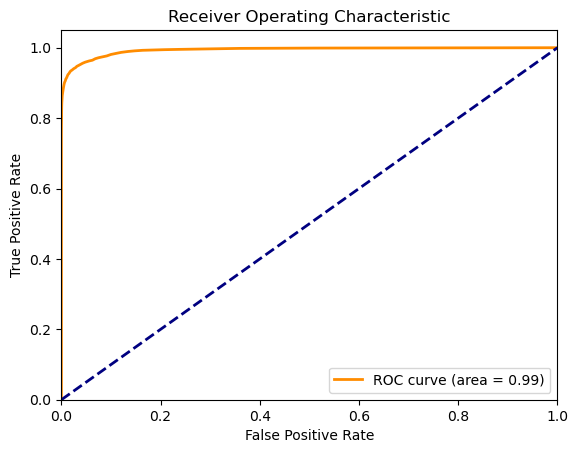

In [101]:
# Mapea las etiquetas a valores binarios
y_true_binary = [1 if label == "satisfied" else 0 for label in y_test]

# Obtén las probabilidades de predicción del modelo (por ejemplo, un clasificador de bosque aleatorio)
probs = classifier.predict_proba(X_test)  # X_test son las características de prueba

# Calcula la curva ROC especificando pos_label=1
fpr, tpr, umbrales = roc_curve(y_true_binary, probs[:, 1], pos_label=1)

# Calcula el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()